<a href="https://colab.research.google.com/github/yudegaki/Kaggle/blob/master/MNIST/CNN(ResNet)_kuzushiji_load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Fri Sep  6 04:42:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
! python3 -m pip install -U chainer

     |████████████████████████████████| 880kB 6.4MB/s 
  Created wheel for chainer: filename=chainer-6.3.0-cp36-none-any.whl size=883589 sha256=18051d2046ddd0580e1eac8f6270d908274501f8d122d3e2d007629d1719cc4c
  Stored in directory: /root/.cache/pip/wheels/bf/fb/7d/cda50b99114b987a82c3819bebee7259e20e5a1d6113b3f6ac
Successfully built chainer
  Found existing installation: typing 3.7.4.1
    Uninstalling typing-3.7.4.1:
      Successfully uninstalled typing-3.7.4.1
  Found existing installation: chainer 5.4.0
    Uninstalling chainer-5.4.0:
      Successfully uninstalled chainer-5.4.0


In [0]:
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
from chainer.datasets import LabeledImageDataset
import cupy as xp

import matplotlib.pyplot as plt

from PIL import Image
import PIL.ImageOps

/usr/local/lib/python3.6/dist-packages/chainer/_environment_check.py:73: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda100) version 5.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda100>=6.3.0,<7.0.0'

See the following page for more details:
  https://docs-cupy.chainer.org/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


In [0]:
class CNN(chainer.Chain):
    def __init__(self, n_units, n_out):
        w = chainer.initializers.HeNormal(0.1)
        super(CNN, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.c1_1 = L.Convolution2D(None,64,3,1,1,initialW=w)
            self.b1_1 = L.BatchNormalization(64)
            self.c1_2 = L.Convolution2D(None,64,3,1,1,initialW=w)  # n_units -> n_units
            self.b1_2 = L.BatchNormalization(64)
            
            self.c2_1 = L.Convolution2D(None,128,3,1,1,initialW=w)  # n_units -> n_out
            self.b2_1 = L.BatchNormalization(128)
            self.c2_2 = L.Convolution2D(None,128,3,1,1,initialW=w)
            self.b2_2 = L.BatchNormalization(128)
            
            self.c3_1 = L.Convolution2D(None,256,3,1,1,initialW=w)
            self.b3_1 = L.BatchNormalization(256)
            self.c3_2 = L.Convolution2D(None,256,3,1,1,initialW=w)
            self.b3_2 = L.BatchNormalization(256)
            self.c3_3 = L.Convolution2D(None,256,3,1,1,initialW=w)
            self.b3_3 = L.BatchNormalization(256)
            
            self.c4_1 = L.Convolution2D(None,512,3,1,1,initialW=w)
            self.b4_1 = L.BatchNormalization(512)
            self.c4_2 = L.Convolution2D(None,512,3,1,1,initialW=w)
            self.b4_2 = L.BatchNormalization(512)
            self.c4_3 = L.Convolution2D(None,512,3,1,1,initialW=w)
            self.b4_3 = L.BatchNormalization(512)
            
            self.c5_1 = L.Convolution2D(None,512,3,1,1,initialW=w)
            self.b5_1 = L.BatchNormalization(512)
            self.c5_2 = L.Convolution2D(None,512,3,1,1,initialW=w)
            self.b5_2 = L.BatchNormalization(512)
            self.c5_3 = L.Convolution2D(None,512,3,1,1,initialW=w)
            self.b5_3 = L.BatchNormalization(512)
            
            self.l_1 = L.Linear(None,4096)
            self.l_2 = L.Linear(None,1024)
            self.l_3 = L.Linear(None,10)

    def forward(self, x):
        h = F.relu(self.b1_1(self.c1_1(x)))
        _h = F.relu(self.b1_2(self.c1_2(h)))
        h = F.add(h,_h)
        h = F.max_pooling_2d(h,2,2)
        
        h = F.relu(self.b2_1(self.c2_1(h)))
        _h = F.relu(self.b2_2(self.c2_2(h)))
        h = F.add(h,_h)
        h = F.max_pooling_2d(h,2,2)
    
        h = F.relu(self.b3_1(self.c3_1(h)))
        _h = F.relu(self.b3_2(self.c3_2(h)))
        h = F.add(h,_h)
        _h = F.relu(self.b3_3(self.c3_3(h)))
        h = F.add(h,_h)
        h = F.max_pooling_2d(h,2,2)
        
        h = F.relu(self.b4_1(self.c4_1(h)))
        _h = F.relu(self.b4_2(self.c4_2(h)))
        h = F.add(h,_h)
        _h = F.relu(self.b4_3(self.c4_3(h)))
        h = F.add(h,_h)
        h = F.max_pooling_2d(h,2,2)
        
        h = F.relu(self.b5_1(self.c5_1(h)))
        _h = F.relu(self.b5_2(self.c5_2(h)))
        h = F.add(h,_h)
        _h = F.relu(self.b5_3(self.c5_3(h)))
        h = F.add(h,_h)
        h = F.max_pooling_2d(h,2,2)
        
        h = F.relu(self.l_1(h))
        h = F.relu(self.l_2(h))
        
        return self.l_3(h)

In [0]:
parser = argparse.ArgumentParser(description='Chainer example: MNIST')

batchsize=100
#('--batchsize', '-b', type=int, default=100,help='Number of images in each mini-batch')
epoch=20
#('--epoch', '-e', type=int, default=20,help='Number of sweeps over the dataset to train')
frequency=-1
#parser.add_argument('--frequency', '-f', type=int, default=-1,help='Frequency of taking a snapshot')
device=0
#parser.add_argument('--device', '-d', type=str, default='-1',help='Device specifier. Either ChainerX device ''specifier or an integer. If non-negative integer, ''CuPy arrays with specified device id are used. If ''negative integer, NumPy arrays are used')
out='result'
#parser.add_argument('--out', '-o', default='result',help='Directory to output the result')
resume=None
#parser.add_argument('--resume', '-r', type=str,help='Resume the training from snapshot')
autoload=False
#parser.add_argument('--autoload', action='store_true',help='Automatically load trainer snapshots in case'' of preemption or other temporary system failure')
unit=1000
#parser.add_argument('--unit', '-u', type=int, default=1000,help='Number of units')

# device = chainer.get_device(device)

print('Device: {}'.format(device))
print('# unit: {}'.format(unit))
print('# Minibatch-size: {}'.format(batchsize))
print('# epoch: {}'.format(epoch))
print('')

Device: 0
# unit: 1000
# Minibatch-size: 100
# epoch: 20



In [0]:
model = L.Classifier(CNN(unit,10))

chainer.serializers.load_npz('./drive/My Drive/MNIST/result_ResNet.npz',model)

model.to_gpu(device)

In [0]:
train, test = chainer.datasets.get_kuzushiji_mnist(ndim=3)

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize,repeat=False,shuffle=False)

labels = chainer.datasets.get_kuzushiji_mnist_labels()

In [0]:
from google.colab import files
files.upload()

Saving DSC_0089.JPG to DSC_0089.JPG


{'DSC_0089.JPG': b'\xff\xd8\xff\xe1$\x94Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\n\x01\x0e\x00\x02\x00\x00\x00\t\x00\x00\x00\x86\x01\x0f\x00\x02\x00\x00\x00\x06\x00\x00\x00\x90\x01\x10\x00\x02\x00\x00\x00\x07\x00\x00\x00\x96\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00\x9e\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00\xa6\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x012\x00\x02\x00\x00\x00\x14\x00\x00\x00\xae\x02\x13\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00\xc2\x88%\x00\x04\x00\x00\x00\x01\x00\x00\x02\x9e\x00\x00\x02\xb8DSC_0089\x00\x00SHARP\x00SH-M05\x00\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x012019:09:06 14:43:51\x00\x00\x1c\x82\x9a\x00\x05\x00\x00\x00\x01\x00\x00\x02\x18\x82\x9d\x00\x05\x00\x00\x00\x01\x00\x00\x02 \x88\'\x00\x03\x00\x00\x00\x01\x00(\x00\x00\x90\x00\x00\x07\x00\x00\x00\x040230\x90\x03\x00\x02\x00\x00\x00\x14\x00\x00\x02(\x90\x04\x00\x02\x00\x00\x00\x14\x00\x00\x02<\x91\x01\x00\x07\x00\x00\x00\x04\x01\x02\x03\x0

Please Input File Name
DSC_0089.JPG


(1, 1, 28, 28)

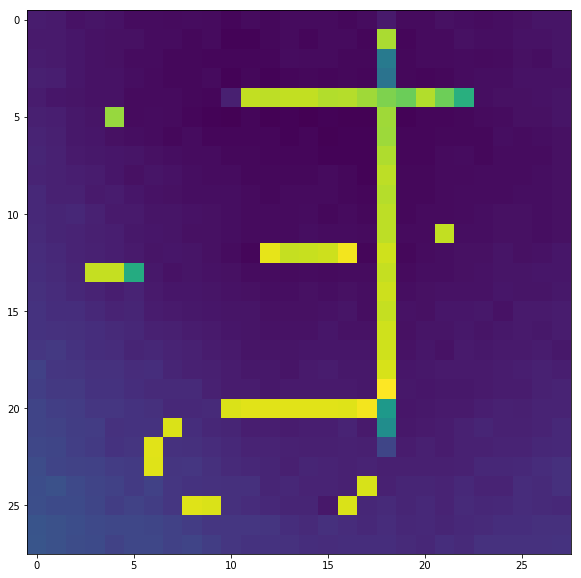

In [0]:
print("Please Input File Name")
f_name = input()
image = Image.open('./'+f_name)
# to glay scale
image = image.convert('L')
inverted_image = PIL.ImageOps.invert(image)
img_resize = inverted_image.resize((28,28))
plt.figure(figsize=(10,10))
plt.imshow(img_resize)

result_img = xp.asarray(img_resize,dtype=xp.float32)/255
result_img = result_img[None,None,...]
result_img.shape

In [0]:
data = train_iter.next()

In [0]:
#labels[data[16][1]]

In [0]:
with chainer.using_config('train', False):
    #y = model.predictor(xp.asarray(data[16][0])[None,...])
    y = model.predictor(result_img)
    print(xp.max(F.softmax(y).array))
    print(labels[int(xp.argmax(F.softmax(y).array))])

0.8456812
('ma', 'ま')


In [0]:
print(F.softmax(y).array[:,9])

[0.00070793]
